### Run the basic implementation

In [1]:
import jax

In [2]:
import jax.numpy as jnp

In [3]:
X = jnp.array([[0.1, 0.4], [0.1, 0.5], [0.1, 0.6]])  # input example
y = jnp.array([[0.1, 0.7]])  # expected output
W = jnp.array([[0., 1., 0., 1., 0., 1.], [0., 1., 0, 1., 0., 1.]])  # random neural network parameters
b = jnp.array([0.1])  # random neural network bias

In [4]:
def forecast_1step(X:jnp.array, W:jnp.array, b:jnp.array)->jnp.array:
    # JAX does not support in-place operations like numpy, so use jax.numpy and functional updates.
    # X = X.copy()  # Copy the input data to avoid modifying the original data
    X_flatten = X.flatten()
    y_next = jnp.dot(W, X_flatten) + b
    return y_next

In [5]:
def forecast(horizon:int, X:jnp.array, W:jnp.array, b:jnp.array)->jnp.array:
    result = []

    # Loop over 'horizon' to predict future values
    for t in range(horizon):
        X_flatten = X.flatten()  # Flatten the window for dot product

        # Get the next prediction
        y_next = forecast_1step(X_flatten, W, b)

        # Update X by shifting rows and adding the new prediction in the last row
        X = jnp.roll(X, shift=-1, axis=0)  # Shift rows to the left
        X = X.at[-1].set(y_next)  # Update the last row with the new prediction

        # Append the prediction to results
        result.append(y_next)

    return jnp.array(result)

In [6]:
def forecast_1step_with_loss(params:tuple, X:jnp.array, y:jnp.array)->float:
    W, b = params
    y_next = forecast_1step(X, W, b)
    return jnp.sum((y_next - y) ** 2)

In [7]:
grad = jax.grad(forecast_1step_with_loss)
def training_loop(grad:callable, num_epochs:int, W:jnp.array, b:jnp.array, X:jnp.array, y:jnp.array)->tuple:
    for i in range(num_epochs):
        delta = grad((W, b), X, y)
        W -= 0.1 * delta[0]
        b -= 0.1 * delta[1]
    return W, b

In [8]:
num_forecaster = 3 # <---- TODO: scale the number as you wish
noise_std = 0.1 # the training needs to have different initial conditions for producing different predictions

aggregated_forecasting=[]
for i in range(num_forecaster): # <------------  TODO: use HPC to manage 'many' forecasters (e.g., 500)
    key = jax.random.PRNGKey(i)  # `i` random seed
    W_noise = jax.random.normal(key, W.shape) * noise_std
    b_noise = jax.random.normal(key, b.shape) * noise_std

    W_init = W + W_noise
    b_init = b + b_noise

    W_trained, b_trained = training_loop(grad, 20, W_init, b_init, X, y)
    y_predicted = forecast(5, X, W_trained, b_trained)

    aggregated_forecasting.append(y_predicted)

print(f"Predictions: ", aggregated_forecasting)


Predictions:  [Array([[0.11162531, 0.68837464],
       [0.2755853 , 0.9555247 ],
       [0.5107062 , 1.3915938 ],
       [0.92911935, 2.1567388 ],
       [1.7098128 , 3.5681267 ]], dtype=float32), Array([[0.10507828, 0.6949219 ],
       [0.2887861 , 0.9879814 ],
       [0.5681674 , 1.4465749 ],
       [1.0338559 , 2.262     ],
       [1.9005349 , 3.7623703 ]], dtype=float32), Array([[0.10564435, 0.69435585],
       [0.2931111 , 0.9908385 ],
       [0.56850266, 1.5075132 ],
       [1.1012038 , 2.4804864 ],
       [2.1495576 , 4.343955  ]], dtype=float32)]


### Train the forecasters in parallel with mpi4py

In [1]:
from mpi4py import MPI

In [2]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [11]:
# Initialize parameters
num_forecaster = 4
forecasters_per_rank = num_forecaster // size  # Divide forecasters among processes
noise_std = 0.1

In [ ]:
start_idx = rank * forecasters_per_rank
end_idx = start_idx + forecasters_per_rank
if rank == size - 1:  # Last process may handle extra forecasters
    end_idx = num_forecaster


#### Run the script for testing weak scalability 

To test weak scalability, the number of tasks per process should remain constant, so I have increased (doubled) the number of forecasters and processes in each run and then plotted the results to see the weak scalability performance of the code. 

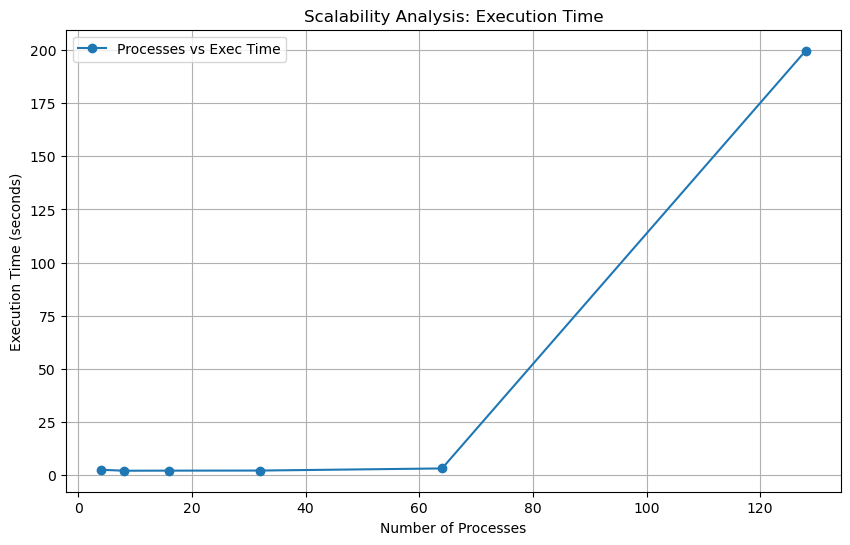

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
file_path = 'scalability_results_weak.csv'
data = pd.read_csv(file_path)
# Plot execution time against number of processes and number of forecasters
plt.figure(figsize=(10, 6))
plt.plot(data['num_processes'], data['exec_time'], marker='o', label='Processes vs Exec Time')
# plt.plot(data['num_forecasters'], data['exec_time'], marker='x', label='Forecasters vs Exec Time')

# Add labels, legend, and title
plt.xlabel('Number of Processes')
plt.ylabel('Execution Time (seconds)')
plt.title('Scalability Analysis: Execution Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

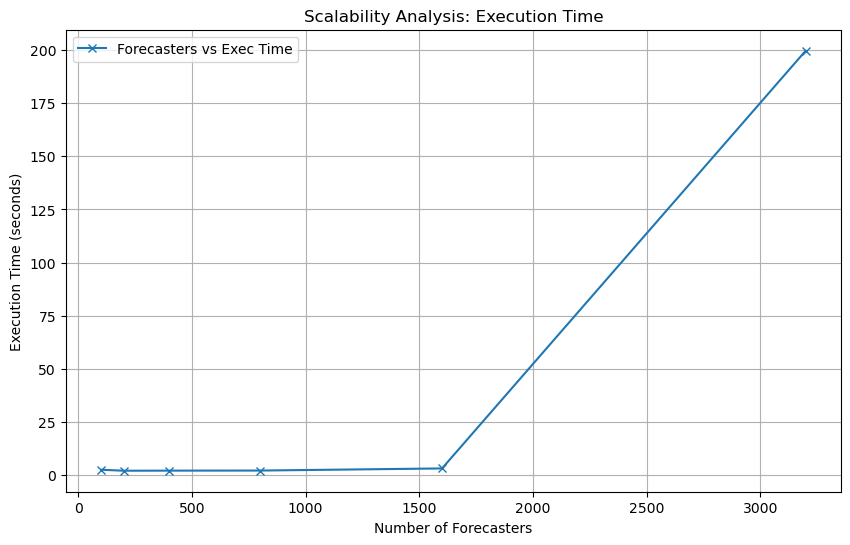

In [7]:
# Plot execution time against number of forecasters
plt.figure(figsize=(10, 6))
# plt.plot(data['num_processes'], data['exec_time'], marker='o', label='Processes vs Exec Time')
plt.plot(data['num_forecasters'], data['exec_time'], marker='x', label='Forecasters vs Exec Time')

# Add labels, legend, and title
plt.xlabel('Number of Forecasters')
plt.ylabel('Execution Time (seconds)')
plt.title('Scalability Analysis: Execution Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Run strong scalability tests 

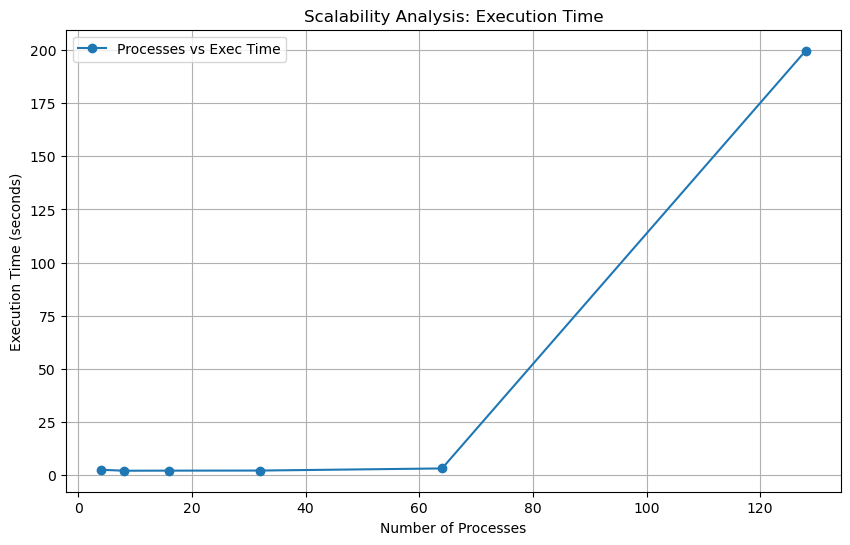

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
file_path = 'scalability_results_weak.csv'
data = pd.read_csv(file_path)
# Plot execution time against number of processes and number of forecasters
plt.figure(figsize=(10, 6))
plt.plot(data['num_processes'], data['exec_time'], marker='o', label='Processes vs Exec Time')
# plt.plot(data['num_forecasters'], data['exec_time'], marker='x', label='Forecasters vs Exec Time')

# Add labels, legend, and title
plt.xlabel('Number of Processes')
plt.ylabel('Execution Time (seconds)')
plt.title('Scalability Analysis: Execution Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The plot illustrates the relationship between execution time and the number of processes:

Processes vs. Execution Time: As the number of processes increases, the execution time initially decreases, indicating improved performance due to parallel processing. However, at higher process counts, the execution time stabilizes or slightly increases, suggesting diminishing returns or overhead from managing many processes.

These observations suggest that optimal performance lies in balancing the number of processes with the task's computational requirements to avoid unnecessary overhead. 

To do some benchmarking studies, `parallel_forecasters.py`, `mpi_script.py`, `run_parallel_forecasting.sh`  were used where each combination of processes and forecasters was run 30 times. The results are stored in `weak` folder. The plots below will give more information regarding the data.

In [10]:
import os
import pandas as pd
# Define the folder path and fieldnames
folder_path = "weak"
# Iterate through all CSV files in the folder
exec_time_avg = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file without a header
        data = pd.read_csv(file_path, header=None)
        exec_time_avg.append(data[2])
       
        


In [23]:
import os
import pandas as pd

# Define the folder containing the CSV files
folder_path = "weak"

# Initialize an empty DataFrame to store results
results = []

# Iterate through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file without header
        data = pd.read_csv(file_path, header=None)
        
        # Assign meaningful column names to the first three columns
        data.columns = ["num_forecasters", "num_processes", "exec_time"] + list(data.columns[3:])

          # Convert exec_time to numeric, coercing errors to NaN
        data["exec_time"] = pd.to_numeric(data["exec_time"], errors="coerce")
        
        # Drop rows where exec_time is NaN
        data = data.dropna(subset=["exec_time"])
        
        # Group by num_forecasters and num_processes, and compute the average exec_time
        grouped = data.groupby(["num_forecasters", "num_processes"])["exec_time"].mean().reset_index()
        
        # Append to the results
        results.append(grouped)



In [24]:

# Combine all results into a single DataFrame
summary_df = pd.concat(results, ignore_index=True)

# Save the consolidated DataFrame to a CSV file (optional)
output_path = os.path.join(folder_path, "consolidated_avg_exec_time.csv")
summary_df.to_csv(output_path, index=False)

print(f"Consolidated results saved to {output_path}.")

Consolidated results saved to weak/consolidated_avg_exec_time.csv.


In [26]:
data = pd.read_csv(output_path)

In [30]:
# Group by num_forecasters and num_processes, and calculate the mean exec_time
averaged_data = data.groupby(["num_forecasters", "num_processes"], as_index=False)["exec_time"].mean()


,num_forecasters,num_processes,exec_time
0,50,2,2.066786
1,75,3,2.073777
2,100,4,2.074834
3,150,6,2.087447
4,200,8,2.099595
5,300,12,2.117447
6,350,14,2.115097
7,400,16,2.121695
8,450,18,2.136130
9,800,32,2.196473


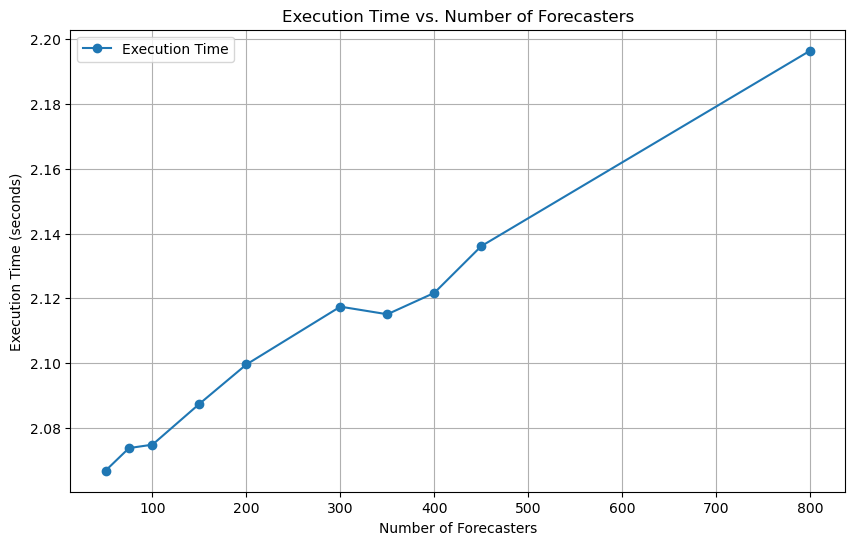

In [31]:
import matplotlib.pyplot as plt

# Plot exec_time vs. num_forecasters
plt.figure(figsize=(10, 6))
plt.plot(averaged_data["num_forecasters"], averaged_data["exec_time"], marker="o", label="Execution Time")

plt.title("Execution Time vs. Number of Forecasters")
plt.xlabel("Number of Forecasters")
plt.ylabel("Execution Time (seconds)")
plt.grid(True)
plt.legend()
plt.show()


The plot shows that as the number of forecasters increases, the execution time also goes up, which makes sense because there's more work to handle. However, the increase isn’t perfectly smooth—at higher numbers, it gets steeper, possibly due to communication delays or system limits. If there are any sudden spikes or drops, they might point to unusual behavior or inefficiencies worth looking into. Overall, it suggests there’s room to tweak how the workload is distributed to improve performance.